In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
import random
from math import exp
#import xgboost as xgb

random.seed(321)
np.random.seed(321)


# acquire data
data_path = "D:/CWA/Kaggle/TwoSigmaConnect/"
X_train = pd.read_json(data_path + "train.json/train.json")
X_test = pd.read_json(data_path + "test.json/test.json")

interest_level_map = {'low': 0, 'medium': 1, 'high': 2}
X_train['interest_level'] = X_train['interest_level'].apply(lambda x: interest_level_map[x])
X_test['interest_level'] = -1

#add features
feature_transform = CountVectorizer(stop_words='english', max_features=150)
X_train['features'] = X_train["features"].apply(lambda x: " ".join(["_".join(i.lower().split(" ")) for i in x]))
X_test['features'] = X_test["features"].apply(lambda x: " ".join(["_".join(i.lower().split(" ")) for i in x]))
feature_transform.fit(list(X_train['features']) + list(X_test['features']))

train_size = len(X_train)
low_count = len(X_train[X_train['interest_level'] == 0])
medium_count = len(X_train[X_train['interest_level'] == 1])
high_count = len(X_train[X_train['interest_level'] == 2])

def find_objects_with_only_one_record(feature_name):
    temp = pd.concat([X_train[feature_name].reset_index(), 
                      X_test[feature_name].reset_index()])
    temp = temp.groupby(feature_name, as_index = False).count()
    return temp[temp['index'] == 1]

managers_with_one_lot = find_objects_with_only_one_record('manager_id')
buildings_with_one_lot = find_objects_with_only_one_record('building_id')
addresses_with_one_lot = find_objects_with_only_one_record('display_address')

lambda_val = None
k=5.0
f=1.0
r_k=0.01 
g = 1.0

def categorical_average(variable, y, pred_0, feature_name):
    def calculate_average(sub1, sub2):
        s = pd.DataFrame(data = {
                                 variable: sub1.groupby(variable, as_index = False).count()[variable],                              
                                 'sumy': sub1.groupby(variable, as_index = False).sum()['y'],
                                 'avgY': sub1.groupby(variable, as_index = False).mean()['y'],
                                 'cnt': sub1.groupby(variable, as_index = False).count()['y']
                                 })
                                 
        tmp = sub2.merge(s.reset_index(), how='left', left_on=variable, right_on=variable) 
        del tmp['index']                       
        tmp.loc[pd.isnull(tmp['cnt']), 'cnt'] = 0.0
        tmp.loc[pd.isnull(tmp['cnt']), 'sumy'] = 0.0

        def compute_beta(row):
            cnt = row['cnt'] if row['cnt'] < 200 else float('inf')
            return 1.0 / (g + exp((cnt - k) / f))
            
        if lambda_val is not None:
            tmp['beta'] = lambda_val
        else:
            tmp['beta'] = tmp.apply(compute_beta, axis = 1)
            
        tmp['adj_avg'] = tmp.apply(lambda row: (1.0 - row['beta']) * row['avgY'] + row['beta'] * row['pred_0'],
                                   axis = 1)
                                   
        tmp.loc[pd.isnull(tmp['avgY']), 'avgY'] = tmp.loc[pd.isnull(tmp['avgY']), 'pred_0']
        tmp.loc[pd.isnull(tmp['adj_avg']), 'adj_avg'] = tmp.loc[pd.isnull(tmp['adj_avg']), 'pred_0']
        tmp['random'] = np.random.uniform(size = len(tmp))
        tmp['adj_avg'] = tmp.apply(lambda row: row['adj_avg'] *(1 + (row['random'] - 0.5) * r_k),
                                   axis = 1)
    
        return tmp['adj_avg'].ravel()
     
    #cv for training set 
    k_fold = StratifiedKFold(5)
    X_train[feature_name] = -999 
    for (train_index, cv_index) in k_fold.split(np.zeros(len(X_train)),
                                                X_train['interest_level'].ravel()):
        sub = pd.DataFrame(data = {variable: X_train[variable],
                                   'y': X_train[y],
                                   'pred_0': X_train[pred_0]})
            
        sub1 = sub.iloc[train_index]        
        sub2 = sub.iloc[cv_index]
        
        X_train.loc[cv_index, feature_name] = calculate_average(sub1, sub2)
    
    #for test set
    sub1 = pd.DataFrame(data = {variable: X_train[variable],
                                'y': X_train[y],
                                'pred_0': X_train[pred_0]})
    sub2 = pd.DataFrame(data = {variable: X_test[variable],
                                'y': X_test[y],
                                'pred_0': X_test[pred_0]})
    X_test.loc[:, feature_name] = calculate_average(sub1, sub2)                               

def transform_data(X):
    #add features    
    feat_sparse = feature_transform.transform(X["features"])
    vocabulary = feature_transform.vocabulary_
    del X['features']
    X1 = pd.DataFrame([ pd.Series(feat_sparse[i].toarray().ravel()) for i in np.arange(feat_sparse.shape[0]) ])
    X1.columns = list(sorted(vocabulary.keys()))
    X = pd.concat([X.reset_index(), X1.reset_index()], axis = 1)
    del X['index']
    
    X["num_photos"] = X["photos"].apply(len)
    X['created'] = pd.to_datetime(X["created"])
    X["num_description_words"] = X["description"].apply(lambda x: len(x.split(" ")))
    X['price_per_bed'] = X['price'] / (X['bedrooms'] + 1)   
    X['price_per_bath'] = X['price'] / (X['bathrooms'] + 1)
    X['price_per_room'] = X['price'] / (X['bathrooms'] + X['bedrooms'] +1 )
    
    X['half_bath'] = X['bathrooms']%1
    #X.loc[X['bathrooms'] == 0, 'half_bath'] = .5
    
  
    X['low'] = 0
    X.loc[X['interest_level'] == 0, 'low'] = 1
    X['medium'] = 0
    X.loc[X['interest_level'] == 1, 'medium'] = 1
    X['high'] = 0
    X.loc[X['interest_level'] == 2, 'high'] = 1
    
    X['display_address'] = X['display_address'].apply(lambda x: x.lower().strip())
    X['street_address'] = X['street_address'].apply(lambda x: x.lower().strip())
    
    X['pred0_low'] = low_count * 1.0 / train_size
    X['pred0_medium'] = medium_count * 1.0 / train_size
    X['pred0_high'] = high_count * 1.0 / train_size
    
    X.loc[X['manager_id'].isin(managers_with_one_lot['manager_id'].ravel()), 
          'manager_id'] = "-1"
    X.loc[X['building_id'].isin(buildings_with_one_lot['building_id'].ravel()), 
          'building_id'] = "-1"
    X.loc[X['display_address'].isin(addresses_with_one_lot['display_address'].ravel()), 
          'display_address'] = "-1"
          
    return X

def normalize_high_cordiality_data():
    high_cardinality = ["building_id", "manager_id"]
    for c in high_cardinality:
        categorical_average(c, "medium", "pred0_medium", c + "_mean_medium")
        categorical_average(c, "high", "pred0_high", c + "_mean_high")

def transform_categorical_data():
    categorical = ['building_id', 'manager_id', 
                   'display_address', 'street_address']
                   
    for f in categorical:
        encoder = LabelEncoder()
        encoder.fit(list(X_train[f]) + list(X_test[f])) 
        X_train[f] = encoder.transform(X_train[f].ravel())
        X_test[f] = encoder.transform(X_test[f].ravel())
                  

def remove_columns(X):
    columns = ["photos", "pred0_high", "pred0_low", "pred0_medium",
               "description", "low", "medium", "high",
               "interest_level", "created"]
    for c in columns:
        del X[c]

print("Starting transformations")        
X_train = transform_data(X_train)    
X_test = transform_data(X_test) 
y = X_train['interest_level'].ravel()

print("Normalizing high cordiality data...")
normalize_high_cordiality_data()
transform_categorical_data()

remove_columns(X_train)
remove_columns(X_test)

X = X_train

Starting transformations
Normalizing high cordiality data...


In [2]:
# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

# Configure visualisations
%matplotlib inline
mpl.style.use( 'ggplot' )
sns.set_style( 'white' )
pylab.rcParams[ 'figure.figsize' ] = 8 , 6
from sklearn.ensemble import RandomForestClassifier
def plot_variable_importance( X , y , z):
    tree = RandomForestClassifier( random_state = 99 )
    tree.fit( X , y )
    plot_model_var_imp( tree , X , y , z)
    
def plot_model_var_imp( model , X , y , z):
    imp = pd.DataFrame( 
        model.feature_importances_  , 
        columns = [ 'Importance' ] , 
        index = X.columns 
    )
    imp = imp.sort_values( [ 'Importance' ] , ascending = False )
    imp[ : z ].plot( kind = 'barh' )
    print (model.score( X , y ))

round:K1
KNN: 0.77894
LOG: 0.73150
RFC: 0.57687
GBR: 0.58058
MLP: 0.69533
0.984627022938
round:K2
KNN: 0.77958
LOG: 0.71893
RFC: 0.56284


KeyboardInterrupt: 

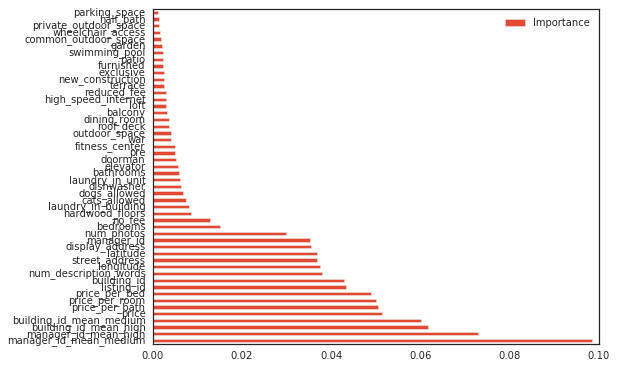

In [14]:
# stratified kfold cv
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import log_loss

skf = StratifiedKFold(n_splits=4)
i=1
for train_id, valid_id in skf.split(X, y):
    X_train, y_train = X.iloc[train_id], y[train_id]
    X_valid, y_valid = X.iloc[valid_id], y[valid_id]  
    
    # compute the mean value per feature on the training set
    mean_on_train = X_train.mean(axis=0)
    # compute the standard deviation of each feature on the training set
    std_on_train = X_train.std(axis=0)

    # subtract the mean, and scale by inverse standard deviation
    # afterward, mean=0 and std=1
    X_train_scaled = (X_train - mean_on_train) / std_on_train
    # use THE SAME transformation (using training mean and std) on the test set
    X_valid_scaled = (X_valid - mean_on_train) / std_on_train
    
    print("round:K{}".format(i))
    # fitting knn model
    knn = KNeighborsClassifier(n_neighbors=300)
    knn.fit(X_train, y_train)
    y_val_pred = knn.predict_proba(X_valid)
    print("KNN: {:.5f}".format(log_loss(y_valid, y_val_pred)))
    
    # fitting logreg model
    logreg = LogisticRegression(C=.001).fit(X_train, y_train)
    y_val_pred = logreg.predict_proba(X_valid)
    print("LGR: {:.5f}".format(log_loss(y_valid, y_val_pred)))
    
#    # fitting dtc model
#    tree = DecisionTreeClassifier(random_state=0)
#    dtc = tree.fit(X_train, y_train)
#    y_val_pred = dtc.predict_proba(X_valid)
#    print("DTC: {:.5f}".format(log_loss(y_valid, y_val_pred)))
    
    # fitting RF model
    clf = RandomForestClassifier(n_estimators=1000)
    clf.fit(X_train, y_train)
    y_val_pred = clf.predict_proba(X_valid)
    print("RFC: {:.5f}".format(log_loss(y_valid, y_val_pred)))
       
    # fitting gbr model
    gbr = GradientBoostingClassifier(random_state=0).fit(X_train, y_train)
    y_val_pred = gbr.predict_proba(X_valid)
    print("GBR: {:.5f}".format(log_loss(y_valid, y_val_pred)))
    
     # fitting svc model
#    svc = SVC(probability=True).fit(X_train, y_train)
#    y_val_pred = svc.predict_proba(X_valid)
#    print("SVC: {:.5f}".format(log_loss(y_valid, y_val_pred)))
    
    # fitting mlp model
    mlp = MLPClassifier().fit(X_train_scaled, y_train)
    y_val_pred = mlp.predict_proba(X_valid_scaled)
    print("MLP: {:.5f}".format(log_loss(y_valid, y_val_pred)))
    
#    plot_variable_importance( X_train , y_train )

    i = i+1
print("KFCV done!!!")
    

In [25]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB().fit(X_train, y_train)
y_val_pred = gnb.predict_proba(X_valid)
print("GNB: {:.5f}".format(log_loss(y_valid, y_val_pred)))

GNB: 6.84436


In [12]:
# stratified kfold cv
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import log_loss

skf = StratifiedKFold(n_splits=4)
i=1
for train_id, valid_id in skf.split(X, y):
    X_train, y_train = X.iloc[train_id], y[train_id]
    X_valid, y_valid = X.iloc[valid_id], y[valid_id]  
    
    # preprocessing using zero mean and unit variance scaling
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_valid_scaled = scaler.transform(X_valid)   
    
    print("round:K{}".format(i))
# fitting knn model
    knn = KNeighborsClassifier(n_neighbors=300)
    knn.fit(X_train_scaled, y_train)
    y_val_pred = knn.predict_proba(X_valid_scaled)
    print("KNN: {:.5f}".format(log_loss(y_valid, y_val_pred)))
    
#    plot_variable_importance( X_train , y_train , 10)

    i = i+1
print("KFCV done!!!")
    



round:K1
KNN: 0.67305
round:K2
KNN: 0.66612
round:K3


KeyboardInterrupt: 

In [11]:
# import the necessary packages
from sklearn.neighbors import KNeighborsClassifier
from sklearn.grid_search import RandomizedSearchCV
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split
#from imutils import paths
import numpy as np
import argparse
#import imutils
import time
#import cv2
import os

print("[INFO] constructing training/testing split...")
(X_train, X_valid, y_train, y_valid) = train_test_split(
	X, y, test_size=0.3, random_state=42)
# construct the set of hyperparameters to tune
params = {"n_neighbors": np.arange(100, 200, 300),
	"metric": ["euclidean", "cityblock"]}

# tune the hyperparameters via a cross-validated grid search
print("[INFO] tuning hyperparameters via randomized grid search")
model = KNeighborsClassifier()
 

# tune the hyperparameters via a randomized search
grid = RandomizedSearchCV(model, params)
start = time.time()
grid.fit(X_train, y_train)
 
# evaluate the best randomized searched model on the testing
# data
print("[INFO] randomized search took {:.2f} seconds".format(
	time.time() - start))
acc = grid.score(X_valid, y_valid)
print("[INFO] grid search accuracy: {:.2f}%".format(acc * 100))
print("[INFO] randomized search best parameters: {}".format(
	grid.best_params_))

[INFO] constructing training/testing split...
[INFO] tuning hyperparameters via randomized grid search


ValueError: The total space of parameters 2 is smaller than n_iter=10. For exhaustive searches, use GridSearchCV.